Epoch 1/300


C:\Users\Fatima\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.6845 - val_loss: 0.1401
Epoch 2/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1792 - val_loss: 0.0706
Epoch 3/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1531 - val_loss: 0.0523
Epoch 4/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1214 - val_loss: 0.0324
Epoch 5/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0871 - val_loss: 0.0682
Epoch 6/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0997 - val_loss: 0.0676
Epoch 7/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0741 - val_loss: 0.0660
Epoch 8/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0508 - val_loss: 0.0226
Epoch 9/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0275 - val_loss: 0.0158
Epoch 10/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0204 - val_loss: 0.0199
Epoch 11/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0100 - val_loss: 0.0226
Epoch 12/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0159 - val_l

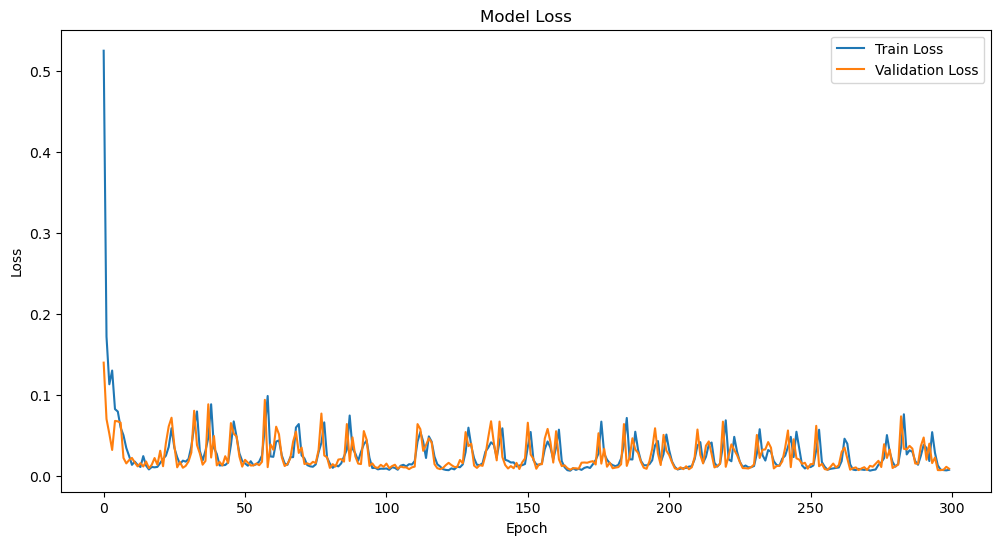

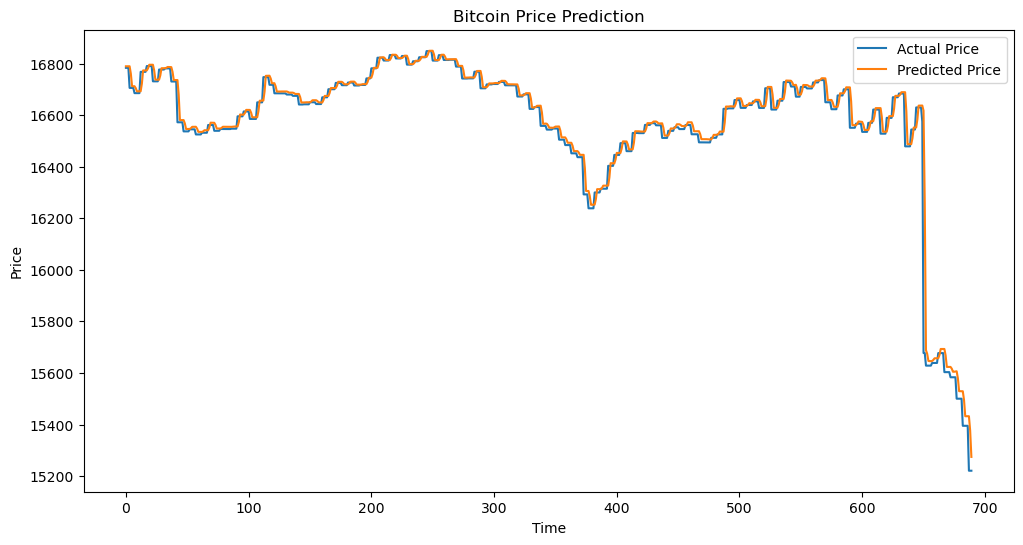

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from math import sqrt
import matplotlib.pyplot as plt

# Function to read and process the bitcoin price data
def read_bitcoin_data(filename):
    df = pd.read_csv(filename, header=None)
    df.columns = ['Price', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'Time']
    return df[['Time', 'Price']]

# Function to read and process the sentiment data
def read_sentiment_data(filename):
    df = pd.read_csv(filename, header=None)
    df.columns = ['Sentiment', 'Time']
    return df

# Load the data
bitcoin_data = read_bitcoin_data('bitcoin.csv')
sentiment_data = read_sentiment_data('tweets.csv')

# Merge the data on the 'Time' column
data = pd.merge(bitcoin_data, sentiment_data, on='Time', how='inner')

# Sort the data by time
data['Time'] = pd.to_datetime(data['Time'], format='%y-%m-%d-%H-%M')
data = data.sort_values('Time')

# Normalize the data
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaler_sentiment = MinMaxScaler(feature_range=(0, 1))
scaled_price = scaler_price.fit_transform(data['Price'].values.reshape(-1, 1))
scaled_sentiment = scaler_sentiment.fit_transform(data['Sentiment'].values.reshape(-1, 1))

# Prepare data for LSTM
def create_dataset(price, sentiment, look_back=2):
    X, y = [], []
    for i in range(len(price) - look_back):
        feature = np.concatenate((price[i:i+look_back], sentiment[i:i+look_back]), axis=1)
        X.append(feature)
        y.append(price[i + look_back])
    return np.array(X), np.array(y)

look_back = 2
X, y = create_dataset(scaled_price, scaled_sentiment, look_back)

# Split the data into train and test sets
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], look_back, 2))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, 2))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, input_shape=(look_back, 2), return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(X_train, y_train, epochs=300, batch_size=100, validation_data=(X_test, y_test), verbose=1, shuffle=False)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler_price.inverse_transform(train_predict)
y_train = scaler_price.inverse_transform(y_train)
test_predict = scaler_price.inverse_transform(test_predict)
y_test = scaler_price.inverse_transform(y_test)

# Calculate RMSE
train_rmse = sqrt(mean_squared_error(y_train, train_predict))
test_rmse = sqrt(mean_squared_error(y_test, test_predict))
print('Train RMSE: %.3f' % train_rmse)
print('Test RMSE: %.3f' % test_rmse)

# Plot training history
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual Price')
plt.plot(test_predict, label='Predicted Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [7]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 2, 100)              │          41,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 365,105 (1.39 MB)

 Trainable params: 121,701 (475.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 243,404 (950.80 KB)

In [16]:
# After model creation and compilation, add these lines:

# 1. Text-based visualization
print("Model Architecture (Text-based):")
model.summary()

# 2. Graphical visualization
try:
    from tensorflow.keras.utils import plot_model
    import os
    
    # Create a directory for the output if it doesn't exist
    os.makedirs('model_visualizations', exist_ok=True)
    
    # Generate and save the model plot
    plot_model(model, 
               to_file='model_visualizations/model_architecture.png', 
               show_shapes=True, 
               show_layer_names=True,
               show_dtype=True,
               expand_nested=True,
               dpi=96)
    print("Graphical model architecture saved as 'model_visualizations/model_architecture.png'")
    
    # Display the image in the notebook (if running in a Jupyter notebook or Google Colab)
    from IPython.display import Image, display
    display(Image('model_visualizations/model_architecture.png'))

except ImportError:
    print("Unable to generate graphical visualization. 'pydot' or 'graphviz' may not be installed.")
    print("You can install them using: !pip install pydot graphviz")
    print("Then, restart your runtime and run the script again.")

# 3. Custom text-based visualization (as a fallback or additional representation)
def custom_model_summary(model):
    print("\nCustom Model Summary:")
    print("=" * 70)
    print(f"{'Layer (type)':<30}{'Output Shape':<25}{'Param #'}")
    print("=" * 70)
    total_params = 0
    for layer in model.layers:
        layer_type = layer.__class__.__name__
        output_shape = str(layer.output_shape)
        params = layer.count_params()
        total_params += params
        print(f"{layer_type:<30}{output_shape:<25}{params}")
    print("=" * 70)
    print(f"Total params: {total_params}")
    print(f"Trainable params: {sum(layer.count_params() for layer in model.trainable_weights)}")
    print(f"Non-trainable params: {sum(layer.count_params() for layer in model.non_trainable_weights)}")

# Call the custom summary function
custom_model_summary(model)

Model Architecture (Text-based):


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 2, 100)              │          41,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 365,105 (1.39 MB)

 Trainable params: 121,701 (475.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 243,404 (950.80 KB)

AttributeError: module 'pydot' has no attribute 'InvocationException'